## Galactic Variability Timescales Figures of Merit ##

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import astropy.units as u
from astropy.coordinates import SkyCoord
from matplotlib.patches import Rectangle

In [6]:
NSIDE = 64

This notebook is designed to present Figures of Merit (FoM) that *very approximately* explore how different categories of galactic variability will benefit or suffer depending on the combination of survey footprint and total number of visits dedicated to this survey region.  

**Assumptions:**
* The distribution of the visits are uniform in time, i.e. intervals between visits are constant
* Equal numbers of visits are obtained in all 6 filters, repeating sequentially, so that color information is obtained

**MAJOR CAVEAT:** this dramatically simplifies the requirements of the science involved, particularly in the distribution of the visits throughout the survey and the relative time allocated to obtaining data in different filters.  This is an unsafe and potentially misleading assumption and caution is strongly advised in interpreting the results on this basis alone. 

### Categorizing variability according to timescale ###

We group all types of galactic stellar variabililty into either transient and periodic phenomena, and consider four very broad categories based on the characteristic *timescale of variability* $\tau_{var}$, since this is the key characteristic affected by changes in lightcurve time sampling when more or fewer visits to a given pointing are made in the course of the survey.  
For transient phenomena, the timescale of variability refers to typical duration of the transient signal, such as the duration of an outburst or explosion, or the Einstein crossing timescale in microlensing.  
For periodic phenomena, the timescale of variability is considered to be the primary periodicity of the object, typically the rotation or orbital period.  

Galactic variability can then be grouped into the following categories according to $\tau_{var}$:
* $<$10 days: including exoplanet & White Dwarf transits, stellar flares, short period stellar binaries, pulsating stars (inc. RR Lyrae, Cepheids), some point-source microlensing (e.g., by free-floating planets, bound planet anomalies, brown dwarfs), most binary microlensing, variability in young stars, short-term accretion variability
* 10-100 days: includes point-source microlensing by galactic stellar-mass lenses (but not binary-lens anomalies), intermediate stellar pulsation periods, disk instability in Cataclysmic Variables, novae
* 100-365 days: includes microlensing by black holes, long-timescale pulsations, 
* $>$365 days: includes long-period variables, e.g. Miras

Although LSST will generate an alert whenever an object varies by more than 5$\sigma$ from the reference flux, for most of Galactic science this is insufficient to reliably detect variability and certainly inadequate to meaningfully classify it.  

Based on previous follow-up experience we require a minimum of 5 observations taken within $\tau_{var}$ to consider a variable target "detectable" in the sense of being able to accurately extract targets of interest from the LSST datastream (for comparison we understand the ZTF estimate that 10 observations are required).  Note that this neglects requirements for multi-color observations in order to simplify the problem.  

Applying this requirement to transient phenomena, we derive a maximum-useful observation interval, $\tau_{obs} = \tau_{var} / 5$ for the four categories above:
* $\tau_{var} < $10 days, $\tau_{obs}$ = 2days
* 10 $<$ $\tau_{var} < $100 days, $\tau_{obs}$ = 2 - 20 days
* 100 $<$ $\tau_{var} < $365 days, $\tau_{obs}$ = 20 - 73 days
* $\tau_{var} > $365 days, $\tau_{obs}$ = 73days

It is often assumed that periodic variables will automatically be detected over the lifetime of LSST.   More precisely, an accurate period, $P$, should be recovered if at least ~5 observations are obtained spanning a range of different phases of the variability period, and this is indeed likely to be true for all $\tau_{var}$ categories by the end of the 10yr survey.  However, *the early identification of periodic variables is critical to the accurate classification of transients*, so waiting until year 10 to identify all periodic variables would severely limit the transient science that can be done, as well as delaying variable star science.  

On the assumption that Galactic Plane visits are uniformly distributed throughout the survey, we therefore consider the detection of periodic variables based on observations taken *only within the first year*.  The maximum-useful observation interval is then set by requiring $\tau_{obs} = P / 5$, leading to the same $\tau_{obs}$ categories as above.

### Galactic Plane Survey Footprint ###

To first order, the spatial distribution of all of these classes of variable follows the distribution of stars in the Milky Way, which we represent using the TVS/SMWLV Galactic Plane priority map.  This map assigns a numerical priority to each HEALpix in the sky according to that pixels importance in Galactic Plane science (as described in Street et al. 2021 https://docushare.lsst.org/docushare/dsweb/Get/Document-37639/Galactic_Plane_Footprint.pdf).

Note that the SDSS-i band map is used here as the most generally-applicable and inclusive reference.  

In [2]:
footprint_maps_dir = os.getenv('FOOTPRINT_MAPS_DIR')
GP_footprint = hp.read_map(os.path.join(footprint_maps_dir,'GalPlane_priority_map_i.fits'), dtype=np.float64)

In [3]:
def galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.25):
    galwfd = np.where(GP_footprint >= healpix_priority_minimum_threshold,1,0)
    return galwfd

To give illustrative examples, the following plots show how the survey footprint changes when we include only the higher-priority areas.

Resolution of HEALpix map: 0.9deg per HEALpix


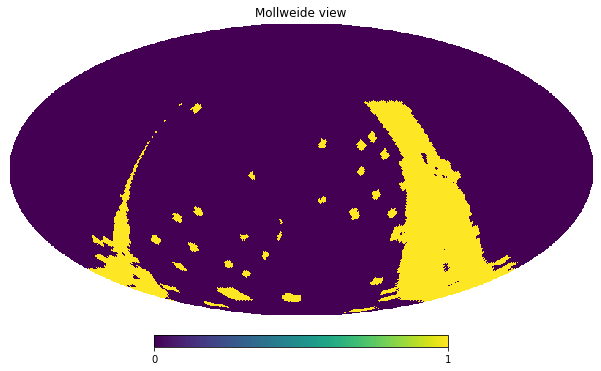

In [10]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.25)
hp.mollview(galwfd, max=1)
print('Resolution of HEALpix map: '+str(round(hp.nside2resol(NSIDE, arcmin=True) / 60,1))+'deg per HEALpix')

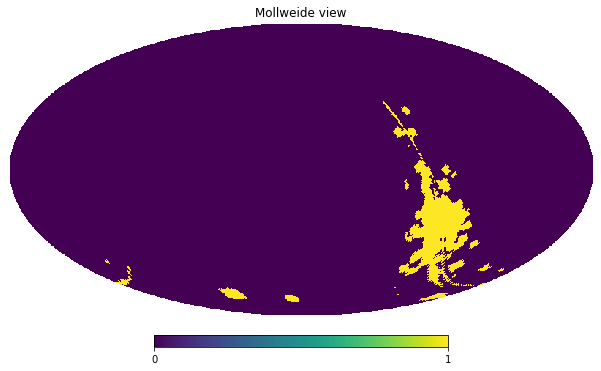

In [5]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.5)
hp.mollview(galwfd, max=1)

One dimension of survey strategy optimization is to consider larger vs smaller footprints in the Galactic Plane, which can be done by lowering or increasing (respectively) the healpix_priority_minimum_threshold.  We estimate the total survey area included in the Galactic Plane as a function of healpix_priority_minimum_threshold as follows.

In [6]:
def estimate_GP_survey_area(galwfd, nside=64):
    gp_area = galwfd.sum() * hp.nside2pixarea(nside, degrees=True)
    return gp_area

In [7]:
priority_range = np.arange(0.1,1.0,0.1)
survey_area = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area[i] = estimate_GP_survey_area(galwfd)
data = np.column_stack((priority_range,survey_area))

Text(0, 0.5, 'Survey area (sq deg)')

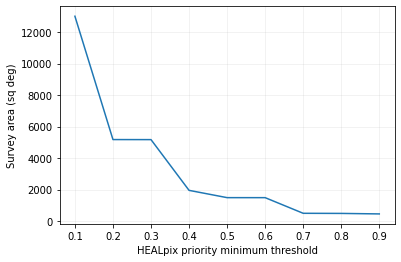

In [8]:
plt.plot(data[:,0], data[:,1])
plt.grid(alpha=0.2)
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey area (sq deg)')

### Survey Time Requirements ###

To estimate the time required to survey a given region, we calculate the observing time required for a single visit, based on 2x15s exposures, with a mean visit time of 42.2s (from https://www.lsst.org/scientists/keynumbers).  

In [3]:
def calc_survey_time(nvisits_per_pointing,survey_area):
    """Estimates the total on-sky observing time used to survey a footprint of a given area, 
    for the number of visits indicated.  Estimate is returned in units of hours."""
    mean_visit_time = 42.2/3600.0  # secs -> hours
    npointings = survey_area / 9.6 # Estimated from the Rubin FOV=9.6 sq deg
    survey_time = mean_visit_time * nvisits_per_pointing * npointings
    return survey_time

To build intuition, let's calculate the amount of time required to survey the Galactic Plane to different HEALpix priority levels, assuming the default 825 visits per field, and compare this with a rough estimate of the total observing time for the LSST survey:

In [10]:
survey_time = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    survey_time[i] = calc_survey_time(825, survey_area[i])
data = np.column_stack((priority_range,survey_area,survey_time))
print(data)

[[1.00000000e-01 1.30048550e+04 1.31008110e+04]
 [2.00000000e-01 5.17508462e+03 5.21326883e+03]
 [3.00000000e-01 5.17172744e+03 5.20988689e+03]
 [4.00000000e-01 1.95051843e+03 1.96491028e+03]
 [5.00000000e-01 1.48806763e+03 1.49904730e+03]
 [6.00000000e-01 1.48722834e+03 1.49820181e+03]
 [7.00000000e-01 4.94343957e+02 4.97991460e+02]
 [8.00000000e-01 4.86790314e+02 4.90382083e+02]
 [9.00000000e-01 4.54897156e+02 4.58253602e+02]]


In [11]:
nyears = 10.0
ndays_per_year = 365.0
nhours_per_night = 9.0
clear_fraction = 0.8
total_lsst_survey_time = nyears * ndays_per_year * nhours_per_night * clear_fraction
print('Total number of hours of observations in LSST = '+str(total_lsst_survey_time)+'hrs')
available_lsst_fraction = 0.1
available_survey_time = total_lsst_survey_time * available_lsst_fraction
print('Estimate number of hours available for non-WFD observations = '+str(available_survey_time)+'hrs')

Total number of hours of observations in LSST = 26280.0hrs
Estimate number of hours available for non-WFD observations = 2628.0hrs


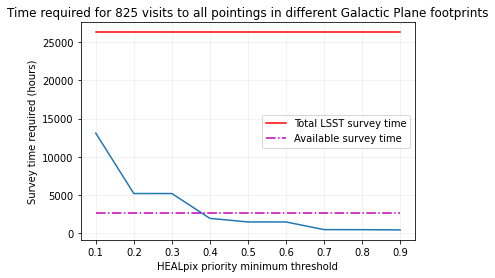

In [12]:
plt.plot(data[:,0], data[:,2])
plt.grid(alpha=0.2)
plt.plot([data[:,0].min(),data[:,0].max()],[total_lsst_survey_time]*2,'r-',label='Total LSST survey time')
plt.plot([data[:,0].min(),data[:,0].max()],[available_survey_time]*2,'m-.',label='Available survey time')
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey time required (hours)')
plt.title('Time required for 825 visits to all pointings in different Galactic Plane footprints')
plt.legend()

### Impact of Number of Observations on Scientific Yield ###

If the total amount of Rubin observing time dedicated to surveying the Galactic Plane has to be reduced due to other scheduling pressures, what impact will this have on galactic variability science?

For simplicity, we assume that if the total number of visits to a field is reduced, the remaining visits are distributed uniformly (in time and in filter selection) and so the interval between visits increases.  We can therefore *roughly* gauge the scientific impact of this change by comparing the inter-visit interval with $\tau_{var}$ and $\tau_{obs}$.  


In [4]:
def ensure_array(entry):
    if type(entry) == type(50) or type(entry) == type(50.0):
        entry = [entry]
    if type(entry) == list:
        entry = np.array(entry)
    return entry

In [5]:
def estimate_visit_interval(nvisits):
    """Function to estimate the interval between visits to a given pointing 
    based on the total number of visits over the lifetime of the survey.  
    This assumes that:
    - Any given field is observable from site for an average of 8 months per year
    - The survey lifetime is 10 years
    - Visits to the field are uniformly distributed
    """
    nvisits = ensure_array(nvisits)
    
    # Estimate the total period of time for which a field can be observed by Rubin
    # over the lifetime of LSST.  Units of hours
    total_time_field_observable = 10.0 * 365.25 * 24.0
    time_observable = np.zeros(len(nvisits))
    time_observable.fill(total_time_field_observable)
    
    # Average interval between visits in hours
    visit_interval = time_observable / nvisits
    
    return visit_interval

In [6]:
def estimate_nvisits(visit_interval):
    """Function to estimate the number of visits over the lifetime of the survey, 
    based on the interval between them.   
    This assumes that:
    - Any given field is observable from site for an average of 8 months per year
    - The survey lifetime is 10 years
    - Visits to the field are uniformly distributed
    """
    visit_interval = ensure_array(visit_interval)
    
    # Estimate the total period of time for which a field can be observed by Rubin
    # over the lifetime of LSST.  Units of hours
    total_time_field_observable = 10.0 * 365.25 * 24.0
    time_observable = np.zeros(len(visit_interval))
    time_observable.fill(total_time_field_observable)
    
    # Average number of visits
    nvisits = time_observable / visit_interval
    
    return nvisits

Text(0.5, 1.0, 'Zoom into short observation intervals')

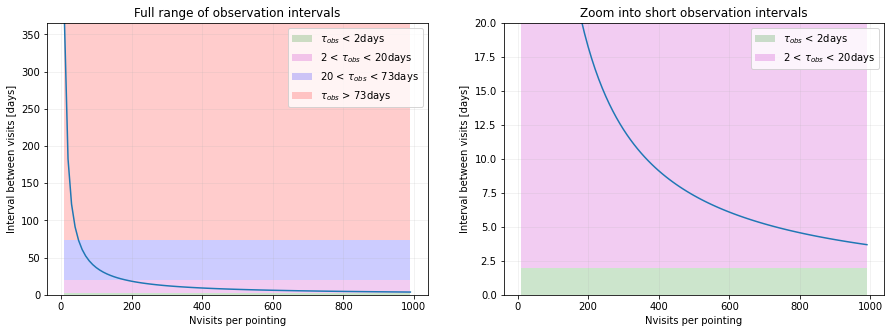

In [16]:
min_nvisits = 10
max_nvisits = 1000
nvisits_range = np.arange(min_nvisits,max_nvisits,10)
visit_intervals = estimate_visit_interval(nvisits_range) / 24.0

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(nvisits_range, visit_intervals)
ax1.grid(alpha=0.2)
ax1.set_xlabel('Nvisits per pointing')
ax1.set_ylabel('Interval between visits [days]')
ax1.fill_between(nvisits_range, 0.0, 2.0, facecolor='green', alpha=0.2, label='$\\tau_{obs}$ < 2days')
ax1.fill_between(nvisits_range, 2.0, 20.0, facecolor='m', alpha=0.2, label='2 < $\\tau_{obs}$ < 20days')
ax1.fill_between(nvisits_range, 20.0, 73.0, facecolor='b', alpha=0.2, label='20 < $\\tau_{obs}$ < 73days')
ax1.fill_between(nvisits_range, 73.0, visit_intervals.max(), facecolor='r', alpha=0.2, label='$\\tau_{obs}$ > 73days')
(xmin,xmax,ymin,ymax) = ax1.axis()
ax1.axis([xmin,xmax,0.0,visit_intervals.max()])
ax1.legend()
ax1.set_title('Full range of observation intervals')


ax2.plot(nvisits_range, visit_intervals)
ax2.grid(alpha=0.2)
ax2.set_xlabel('Nvisits per pointing')
ax2.set_ylabel('Interval between visits [days]')
ax2.fill_between(nvisits_range, 0.0, 2.0, facecolor='green', alpha=0.2, label='$\\tau_{obs}$ < 2days')
ax2.fill_between(nvisits_range, 2.0, 20.0, facecolor='m', alpha=0.2, label='2 < $\\tau_{obs}$ < 20days')
(xmin,xmax,ymin,ymax) = ax2.axis()
ax2.axis([xmin,xmax,0.0,20.0])
ax2.legend()
ax2.set_title('Zoom into short observation intervals')

The plot above illustrates which categories of galactic plane science will be served, given different numbers of total visits, assuming they are distributed uniformly in time and filter selection. **However caution is urged in interpreting these plots** The four $\tau_{obs}$ categories are not considered scientifically equal in the sense that the **majority of high-impact science is contained within the category $\tau_{obs} < 2$ days.**  

If LSST does not provide sufficient numbers of visits to achieve this science, it is possible that some of it may still be achieved through real-time follow-up observations at higher cadence.  This has been demonstrated with microlensing for example, if the survey provides sufficient observations to alert new discoveries at an early stage of the event.  **But we stress that follow-up observations cannot fully compensate for the loss of Rubin observations** particularly at fainter magnitudes, as inadequate time is available at follow-up facilities of sufficient aperture and instrumentation, and the scientific yield of the survey would be substantially diminished.

### Impact of Survey Footprint Area ###

From the plots above, we note that nvisits~500/pointing provides a rough rule-of-thumb as the minimum viable number of visits that would enable science in all four $\tau_{var}$ categories.  We combine this with the Galactic Plane priority map to estimate the total survey time required for different footprints. 

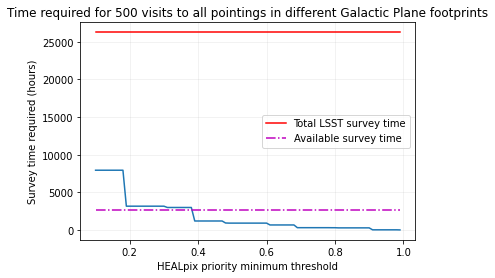

In [17]:
priority_range = np.arange(0.1,1.0,0.01)
survey_area = np.zeros(len(priority_range))
survey_time = np.zeros(len(priority_range))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area[i] = estimate_GP_survey_area(galwfd)
    survey_time[i] = calc_survey_time(500, survey_area[i])
data = np.column_stack((priority_range,survey_area,survey_time))
plt.plot(data[:,0], data[:,2])
plt.grid(alpha=0.2)
plt.plot([data[:,0].min(),data[:,0].max()],[total_lsst_survey_time]*2,'r-',label='Total LSST survey time')
plt.plot([data[:,0].min(),data[:,0].max()],[available_survey_time]*2,'m-.',label='Available survey time')
plt.xlabel('HEALpix priority minimum threshold')
plt.ylabel('Survey time required (hours)')
plt.title('Time required for 500 visits to all pointings in different Galactic Plane footprints')
plt.legend()

This plot implies that using a HEALpix-priority threshold of 0.4 to select fields in the Galactic Plane might be surveyed to an adequate cadence by LSST to enable all of the science considered here.  To illustrate that footprint graphically:

/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In

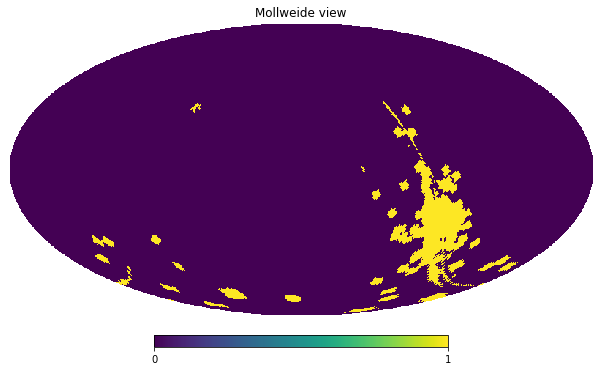

In [18]:
galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold = 0.4)
hp.mollview(galwfd, max=1)

### Galactic Science Figure of Merit ###

A very approximate rule of thumb for galactic science may be derived by combining the above metrics for survey footprint and number of visits per pointing.  To give a sense of scale, we normalize this FoM using intermediate values for survey footprint area of 2000 sq deg. and nvisits_per_pointing of 500, based on the analysis above.  

In [7]:
def GP_FoM_tau_footprint(nvisits_per_pointing,survey_area):
    
    visit_intervals = estimate_visit_interval(nvisits_per_pointing) / 24.0
    FoM = survey_area / visit_intervals
    
    minimum_visit_interval = estimate_visit_interval(500) / 24.0
    fiducial_FoM = 2000.0 / minimum_visit_interval
    
    norm_FoM = FoM/fiducial_FoM
    
    return norm_FoM

We then compute this FoM for a range of survey parameters, spanning ranges of number of visits/pointing and total survey footprint area in the Galactic Plane region.  

In [8]:
def calc_yval(visit_interval, min_nvisits, max_nvisits, scale_min, scale_max):
    """Function to map y-axis parameter values to y-axis scale in the 2D FoM plot"""
    
    nvisits = estimate_nvisits(visit_interval)
    #print('Visit interval='+str(visit_interval)+' -> nvisits='+str(nvisits))
    #print('SCALE: '+str(scale_min)+' '+str(scale_max))
    #print('PARAMETER: '+str(min_nvisits)+' '+str(max_nvisits))
    
    scale_grad = (scale_max - scale_min) / (max_nvisits - min_nvisits)
    
    scale_value = scale_min + scale_grad*nvisits
    #print('Scale gradient: '+str(scale_grad))
    #print('Value on scale: '+str(scale_value))
    
    return scale_value

/Users/rstreet1/software/lsst_tvs_venv/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


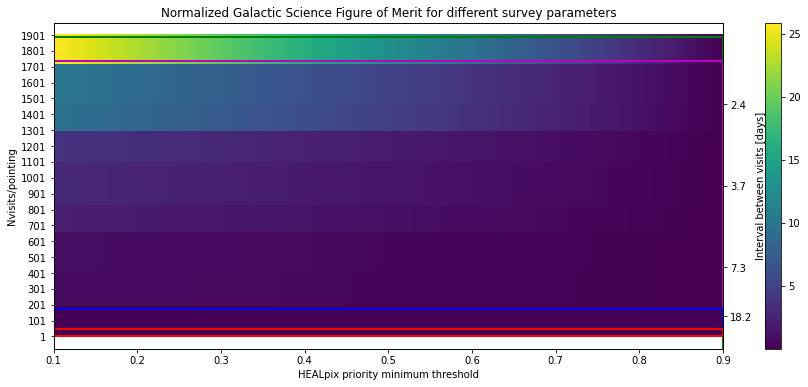

In [21]:
min_nvisits = 1
max_nvisits = 2000
nvisits_range = np.arange(min_nvisits,max_nvisits,10)
visit_intervals = estimate_visit_interval(nvisits_range) / 24.0
min_priority = 0.1
max_priority = 1.0
priority_range = np.arange(min_priority, max_priority,0.01)
FoM = np.zeros((len(priority_range),len(nvisits_range)))
survey_time = np.zeros((len(priority_range),len(nvisits_range)))
for i in range(0,len(priority_range),1):
    galwfd = galPlane_survey_footprint(healpix_priority_minimum_threshold=priority_range[i])
    survey_area = estimate_GP_survey_area(galwfd)
    survey_time[i,:] = calc_survey_time(500, survey_area)
    FoM[i,:] = GP_FoM_tau_footprint(nvisits_range,survey_area)
FoM = np.flip(FoM,1)
fig, ax = plt.subplots(1, 1, figsize=(15,6))
im = ax.imshow(FoM, interpolation='none')
ax.set_xlabel('HEALpix priority minimum threshold')
ax.set_ylabel('Nvisits/pointing')
(xmin,xmax,ymin,ymax) = plt.axis()
priority_intervals = np.arange(min_priority, max_priority, 0.1)
nvisits_intervals = np.arange(min_nvisits,max_nvisits,100)
plt.xticks(np.linspace(xmin,xmax,len(priority_intervals)), [str(round(p,1)) for p in priority_intervals])
plt.yticks(np.linspace(ymin,ymax,len(nvisits_intervals)), [str(round(n)) for n in nvisits_intervals])
plt.colorbar(im)
plt.title('Normalized Galactic Science Figure of Merit for different survey parameters')

ax2 = ax.twinx()
yincr = max_nvisits - min_nvisits
y2entries = np.array([0.1,0.25, 0.5, 0.75])
y2values = min_nvisits + y2entries*yincr
y2range = estimate_visit_interval(y2values) / 24.0

ax2.set_ylabel('Interval between visits [days]')
ax2.set_yticks(y2entries)
ax2.set_yticklabels([str(round(n,1)) for n in y2range])
#ax2.invert_yaxis()
(xmin2,xmax2,ymin2,ymax2) = ax2.axis()
val_max = estimate_visit_interval(min_nvisits ) / 24.0
val_min = estimate_visit_interval(max_nvisits) / 24.0

# Box for tau_obs < 2.0 days [converted to hrs] - green line
sval = calc_yval(2.0*24.0, max_nvisits, min_nvisits, ymin, ymax)
rect = Rectangle((xmin, 0.0), (xmax-xmin), sval, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Box for 2.0 < tau_obs < 20.0 days [converted to hrs] - magenta line
sval1 = calc_yval(2.0*24.0, min_nvisits, max_nvisits, ymin, ymax)
sval2 = calc_yval(20.0*24.0, min_nvisits, max_nvisits, ymin, ymax)
dsval = sval2 - sval1
rect = Rectangle((xmin, sval1), (xmax-xmin), dsval, linewidth=2, edgecolor='m', facecolor='none')
ax.add_patch(rect)

# Box for 20.0 < tau_obs < 73.0 days [converted to hrs] - blue line
sval1 = calc_yval(20.0*24.0, min_nvisits, max_nvisits, ymin, ymax)
sval2 = calc_yval(73.0*24.0, min_nvisits, max_nvisits, ymin, ymax)
dsval = sval2 - sval1
rect = Rectangle((xmin, sval1), (xmax-xmin), dsval, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

# Box for tau_obs > 73.0 days [converted to hrs] - red line
sval1 = calc_yval(73.0*24.0, min_nvisits, max_nvisits, ymin, ymax)
sval2 = min(calc_yval(1000.0*24.0, min_nvisits, max_nvisits, ymin, ymax), ymin)
dsval = sval2 - sval1
rect = Rectangle((xmin, sval1), (xmax-xmin), 2, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

The figure above shows the normalized FoM calculated for a range of survey designs, where the colorbar indicates values of the FoM - higher values are better for the scientific return. 

The x-axis is inversely proportional to survey area.  

The left-hand y-axis represents the number of pointings per field and the right-hand y-axis displays the corresponding interval between sequential observations.  

The superimposed lines indicate the approximate regions where the interval between visits meets the requirements of the $\tau_{obs}$ categories; the color of the box outlines correspond to the plot colors used in the plots of interval between obs vs. Nvisits.  

Survey parameters above these lines should (to first order) serve the needs of the science cases within the corresponding variability timescale category and those with longer $\tau_{obs}$, though the caveats above are again strongly emphasized.  Surveys with larger areas (i.e. a lower priority map threshold) will return proportionally higher science return by including more potential targets.  

### Interpretation ###

Rather than interpret these lines as hard-and-fast rules, we stress that the goal of these plots is to give an intuition regarding the survey designs that most suit the needs of a range of Galactic Plane science.  In general, smaller numbers of visits/pointing will restrict the science return to the longer categories of variability only.  However, a trade-off must be made regarding the total area surveyed, since much of the science interest in LSST is precisely because it will probe larger regions than could hitherto be explored, and for this reason we recommend a maximum priority threshold of ~0.4 (or lower) be used to select sky regions from the priority maps provided.  

However, we again note that further optimizations are possible, including using the priority maps to optimize the filter selection used. 

## Evaluating Survey Cadence and Season Length

In the discussion above we have considered only a fixed median visit interval ($\Delta\tau_{med}$), on the assumption that the observational cadence of every strategy will be uniform throughout the survey lifetime.  However, some survey strategies have highly non-uniform visit intervals, particularly the rolling cadence strategies.  To take this into account, the Figure of Merit above needs some refinement.  

Firstly, we design a metric to evaluate the scientific benefit of sequential observations taken at an interval of $\Delta t$, by comparing this with $\tau_{obs}$ for the four categories of variability.  Observations taken at intervals less than or equal to $\tau_{obs}$ are by definition of high value, and return a metric value of 1.  Observations taken at intervals greater than $\tau_{obs}$ are usually of some value, but the value deteriorates quite quickly with increasingly large gaps relative to $\tau_{obs}$.  We represent this as an exponential decay function with a decay constant of 1/$\tau_{obs}$ in the metric below. 

In [13]:
def calc_visit_interval_metric(delta_t, tau_obs):
    K = 1.0/tau_obs
    
    if type(delta_t) == type(5.0):
        delta_t = np.array([delta_t])
    
    metric = np.zeros(len(delta_t))
    idx = np.where(delta_t <= tau_obs)[0]
    if len(idx) > 0:
        metric[idx] = 1.0
    
    idx = np.where(delta_t > tau_obs)[0]
    if len(idx) > 0:
        metric[idx] = np.exp(-K*(delta_t[idx] - tau_obs))

    return metric

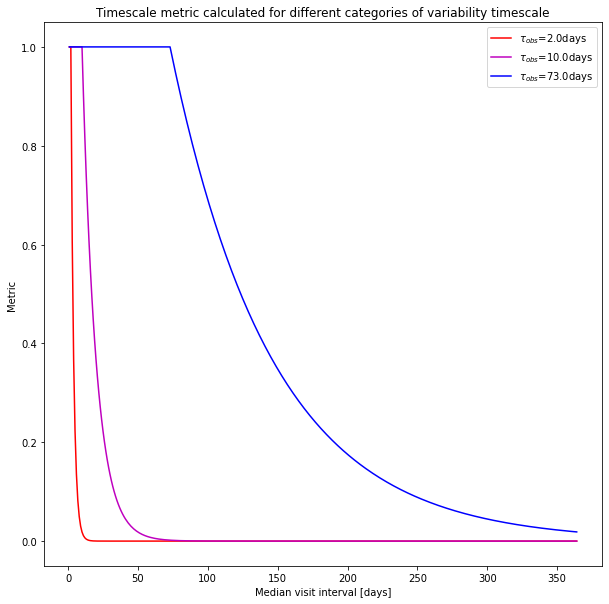

In [14]:
tau_obs_range = [2.0, 10.0, 73.0]
median_visit_intervals = np.array([1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 50.0, 75.0, 100.0, 150.0, 200.0, 365.0])
median_visit_intervals = np.arange(1.0, 365.0, 1.0)
formats = ['r-','m-','b-']

fig,ax = plt.subplots(1, 1, figsize=(10,10))
for i,tau_obs in enumerate(tau_obs_range):
    metric_data = calc_visit_interval_metric(median_visit_intervals, tau_obs)
    ax.plot(median_visit_intervals, metric_data, formats[i], 
            label='$\\tau_{obs}$='+str(tau_obs)+'days')
ax.set_xlabel('Median visit interval [days]')
ax.set_ylabel('Metric')
ax.set_title('Timescale metric calculated for different categories of variability timescale')
ax.legend()

Some survey strategies consist of a set of regular visits to a given field for a period we refer to as a "season", interspaced by much larger gaps between observing seasons; this is particularly true for the rolling cadence proposals.  To evaluate this, we modify the metric above to consider not just $\Delta\tau_{med}$ but also the maximum interval between visits, $\Delta\tau_{max}$.  We derive the median visit intervals as above, and simulate a range of maximum visit intervals up to a limit of 3 years to explore the behaviour of the proposed metric.  This limit was chosen based on the maximum length of the rolling cadence "season" currently being explored, that is dividing the sky into 3 regions.  

In [ ]:
def calc_visit_interval_season_metric(delta_t_median, delta_t_max, tau_obs):
    K = 1.0/tau_obs
    
    if type(delta_t_median) == type(5.0):
        delta_t = np.array([delta_t_median])
    
    if type(delta_t_max) == type(5.0):
        delta_t = np.array([delta_t_max])
    
    terms = []
    for dt in [delta_t_median, delta_t_max]:
        term = np.zeros(len(dt))
        idx = np.where(dt <= tau_obs)[0]
        if len(idx) > 0:
            term[idx] = 1.0

        idx = np.where(dt > tau_obs)[0]
        if len(idx) > 0:
            term[idx] = np.exp(-K*(delta_t[idx] - tau_obs))
        terms.append(term)
    terms = np.array(terms)
    metric = np.prod(terms, axis=1)
    print(metric)
    
    return metric